In [13]:
import numpy as np

class SGDRegressor:
    def __init__(self, lr=0.01, epochs=100, batch_size=32,
                 lr_schedule=None, regularization=None, reg_lambda=0.01):
        self.arithmetic_ops = None
        self.losses = None
        self.w = None
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr_schedule = lr_schedule  # const, step, inverse
        self.regularization = regularization  # L1, L2, Elastic
        self.reg_lambda = reg_lambda

    def _apply_regularization(self, w):
        if self.regularization == 'L2':
            return self.reg_lambda * w
        elif self.regularization == 'L1':
            return self.reg_lambda * np.sign(w)
        elif self.regularization == 'Elastic':
            alpha = 0.5 
            return self.reg_lambda * (alpha * np.sign(w) + (1 - alpha) * w)
        return 0

    def _adjust_lr(self, epoch):
        if self.lr_schedule == 'step':
            return self.lr * (0.1 ** (epoch // 20))
        elif self.lr_schedule == 'inverse':
            return self.lr / (1 + 0.1 * epoch)
        return self.lr

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.losses = []
        self.arithmetic_ops = 0

        for epoch in range(self.epochs):
            lr = self._adjust_lr(epoch)
            indices = np.random.permutation(n_samples)
            X_shuffled, y_shuffled = X[indices], y[indices]

            # for start in range(0, n_samples, self.batch_size):
            end = self.batch_size # start + self.batch_size
            xb = X_shuffled[:end]
            yb = y_shuffled[:end]

            preds = xb @ self.w
            error = preds - yb
            grad = xb.T @ error / len(xb)
            reg_term = self._apply_regularization(self.w)
            self.w -= lr * (grad + reg_term)

            self.arithmetic_ops += xb.shape[0] * xb.shape[1] * 2
            self.arithmetic_ops += xb.shape[1] * xb.shape[1]  # grad
            self.arithmetic_ops += xb.shape[1] * 3  # reg, update

            loss = np.mean((X @ self.w - y) ** 2)
            self.losses.append(loss)

    def predict(self, X):
        return X @ self.w



In [3]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

def generate_data(n_samples=1000, n_features=1, degree=1, noise=0.1):
    X = np.random.rand(n_samples, n_features)
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    true_weights = np.random.randn(X_poly.shape[1])
    y = X_poly @ true_weights + noise * np.random.randn(n_samples)
    return X_poly, y, true_weights

In [4]:
import matplotlib.pyplot as plt

def plot_losses(models, labels):
    for model, label in zip(models, labels):
        plt.plot(model.losses, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.title("SGD Performance Comparison")
    plt.show()

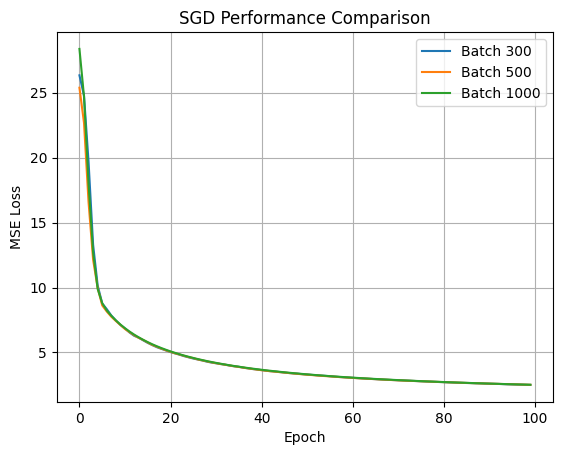

In [5]:
X, y, w = generate_data(n_samples=1000, n_features=20, degree=2, noise=0.5)
models = []
labels = []

for batch in [300, 500, X.shape[0]]:
    model = SGDRegressor(lr=0.1, batch_size=batch, lr_schedule='inverse', regularization='Elastic')
    model.fit(X, y)
    models.append(model)
    labels.append(f"Batch {batch}")

plot_losses(models, labels)


In [6]:
from sklearn.metrics import mean_squared_error
import psutil
import time

def experiment_batch_sizes():
    X, y, true_weights = generate_data(n_samples=7000, n_features=20, degree=2)

    results = []
    batch_sizes = [100, 250, 500, 750, 1000, 3000, 5000, X.shape[0]]

    for batch_size in batch_sizes:
        model = SGDRegressor(epochs=300, lr=0.1, batch_size=batch_size, lr_schedule='inverse', regularization='Elastic')

        time.sleep(1)
        process = psutil.Process()
        mem_before = process.memory_info().rss

        start_time = time.time()
        model.fit(X, y)
        end_time = time.time()

        mem_after = process.memory_info().rss
        mem_usage = (mem_after - mem_before) / 1024 / 1024

        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)

        results.append({
            "batch_size": batch_size,
            "mse": mse,
            "time": end_time - start_time,
            "memory_MB": mem_usage,
            "operations": model.arithmetic_ops
        })

    return results

In [59]:
experiment_batch_sizes()

[{'batch_size': 100,
  'mse': 1.480745402446867,
  'time': 2.0640079975128174,
  'memory_MB': 40.34375,
  'operations': 30076200},
 {'batch_size': 250,
  'mse': 1.4752539221073646,
  'time': 0.842097282409668,
  'memory_MB': 0.19140625,
  'operations': 50866200},
 {'batch_size': 500,
  'mse': 1.4795658025916236,
  'time': 0.9628708362579346,
  'memory_MB': 0.96875,
  'operations': 85516200},
 {'batch_size': 750,
  'mse': 1.4899246018596195,
  'time': 0.8744192123413086,
  'memory_MB': 0.13671875,
  'operations': 120166200},
 {'batch_size': 1000,
  'mse': 1.4820707814726666,
  'time': 0.9720938205718994,
  'memory_MB': 0.0703125,
  'operations': 154816200},
 {'batch_size': 3000,
  'mse': 1.4870141711397102,
  'time': 1.0833861827850342,
  'memory_MB': 0.484375,
  'operations': 432016200},
 {'batch_size': 5000,
  'mse': 1.4877036162079247,
  'time': 1.1391570568084717,
  'memory_MB': 0.765625,
  'operations': 709216200},
 {'batch_size': 7000,
  'mse': 1.4861758489096597,
  'time': 1.2569

In [68]:
def experiment_reg():
    X, y, true_weights = generate_data(n_samples=7000, n_features=20, degree=2)

    results = []
    batch_sizes = [100, 250, 500, 750, 1000, 3000, 5000, X.shape[0]]

    for reg in ['L1', 'L2', 'Elastic']:
        model = SGDRegressor(epochs=300, lr=0.1, batch_size=1000, lr_schedule='inverse', regularization=reg)

        model.fit(X, y)

        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)

        results.append({
            "mse": mse,
            "regularization": reg,
        })
    return results

In [69]:
experiment_reg()

[{'mse': 1.6836179887483018, 'regularization': 'L1'},
 {'mse': 1.5870105908134873, 'regularization': 'L2'},
 {'mse': 1.6312250409197688, 'regularization': 'Elastic'}]

In [70]:
def experiment_lr():
    X, y, true_weights = generate_data(n_samples=7000, n_features=20, degree=2)

    results = []
    batch_sizes = [100, 250, 500, 750, 1000, 3000, 5000, X.shape[0]]

    for lr in ['const', 'step', 'inverse']:
        model = SGDRegressor(epochs=300, lr=0.1, batch_size=1000, lr_schedule=lr, regularization='Elastic')

        model.fit(X, y)

        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)

        results.append({
            "mse": mse,
            "learning rate schedule": lr,
        })
    return results

In [71]:
experiment_lr()

[{'mse': 6.953587872386902e+26, 'learning rate schedule': 'const'},
 {'mse': 1.7693165425688395, 'learning rate schedule': 'step'},
 {'mse': 1.4876844446994073, 'learning rate schedule': 'inverse'}]

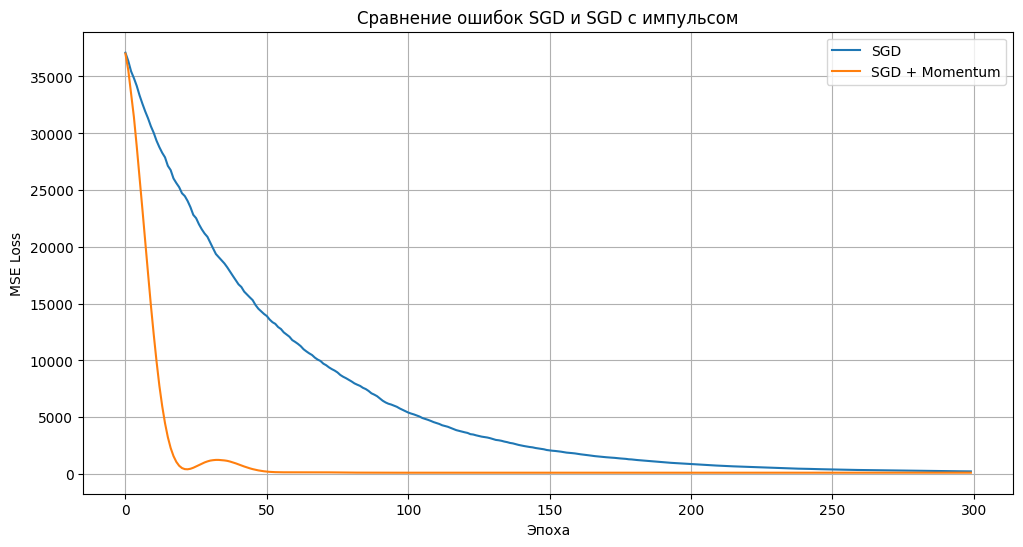

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=20, noise=10.0, random_state=42)
X = StandardScaler().fit_transform(X)
y = y.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class SGDMomentumRegressor:
    def __init__(self, lr=0.01, epochs=100, batch_size=32, momentum=0.9):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.momentum = momentum
        self.losses = []
        self.w = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        velocity = np.zeros(n_features)
        self.losses = []

        for epoch in range(self.epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            xb = X_shuffled[:self.batch_size]
            yb = y_shuffled[:self.batch_size]

            preds = xb @ self.w
            error = preds - yb
            grad = xb.T @ error / len(xb)

            velocity = self.momentum * velocity - self.lr * grad
            self.w += velocity

            loss = np.mean((X @ self.w - y) ** 2)
            self.losses.append(loss)

    def predict(self, X):
        return X @ self.w

sgd = SGDMomentumRegressor(epochs=300, momentum=0)
sgd.fit(X_train, y_train)

momentum_sgd = SGDMomentumRegressor(epochs=300, momentum=0.9)
momentum_sgd.fit(X_train, y_train)

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(sgd.losses, label='SGD')
plt.plot(momentum_sgd.losses, label='SGD + Momentum')
plt.title("Сравнение ошибок SGD и SGD с импульсом")
plt.xlabel("Эпоха")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


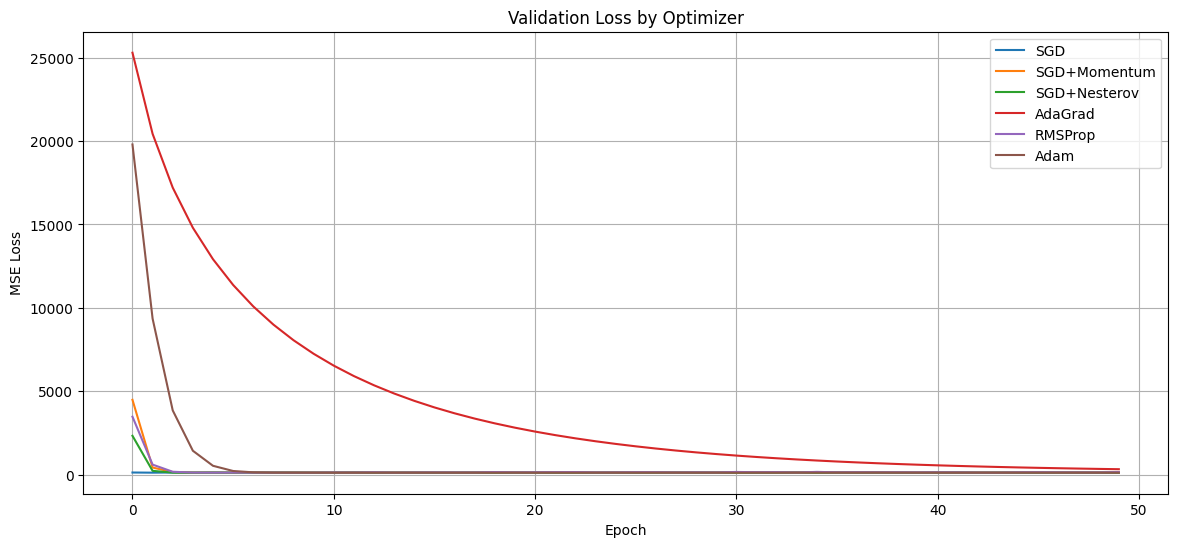

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

X, y = make_regression(n_samples=1000, n_features=20, noise=10.0, random_state=42)
X = StandardScaler().fit_transform(X)
y = y.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32)

# Модель
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Обучение
def train_model(optimizer_class, optimizer_params={}, epochs=50):
    model = SimpleRegressor(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = sum(nn.MSELoss()(model(xb), yb).item() * xb.size(0) for xb, yb in val_loader)
            val_losses.append(val_loss / len(val_loader.dataset))

    return val_losses

optimizers = {
    'SGD': (torch.optim.SGD, {'lr': 0.1}),
    'SGD+Momentum': (torch.optim.SGD, {'lr': 0.01, 'momentum': 0.9}),
    'SGD+Nesterov': (torch.optim.SGD, {'lr': 0.01, 'momentum': 0.9, 'nesterov': True}),
    'AdaGrad': (torch.optim.Adagrad, {'lr': 2}),
    'RMSProp': (torch.optim.RMSprop, {'lr': 1}),
    'Adam': (torch.optim.Adam, {'lr': 1}),
}

results = {name: train_model(cls, params) for name, (cls, params) in optimizers.items()}

plt.figure(figsize=(14, 6))
for name, val_loss in results.items():
    plt.plot(val_loss, label=name)
plt.title("Validation Loss by Optimizer")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()


MSE: 2926.1866923706334


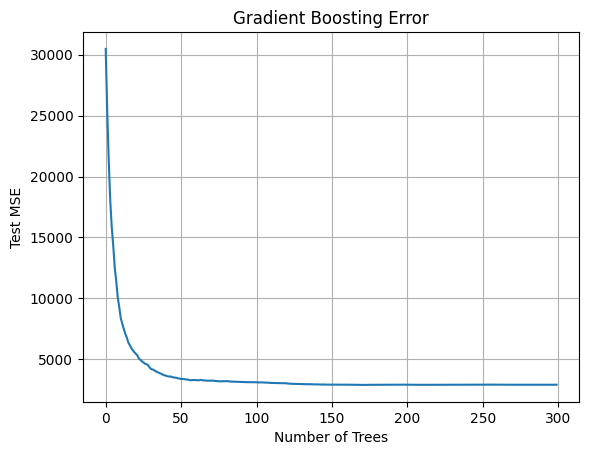

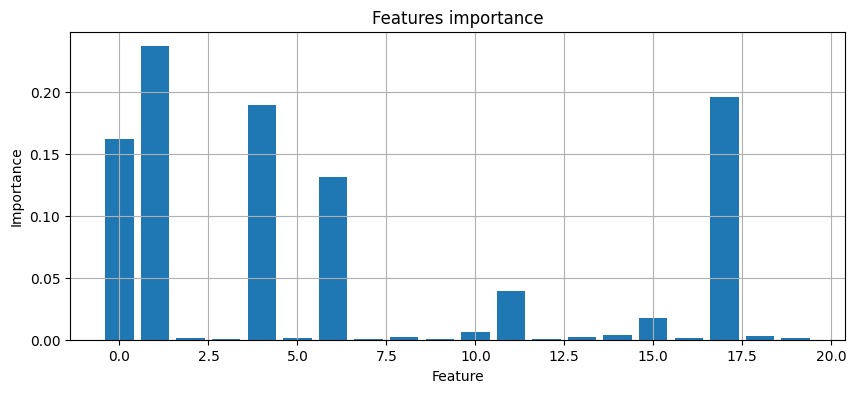

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_regression(n_samples=1000, n_features=20, noise=10.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.3, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

errors = []
for y_pred_stage in model.staged_predict(X_test):
    errors.append(mean_squared_error(y_test, y_pred_stage))

plt.plot(errors)
plt.xlabel("Number of Trees")
plt.ylabel("Test MSE")
plt.title("Gradient Boosting Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(range(X.shape[1]), model.feature_importances_)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Features importance")
plt.grid(True)
plt.show()

